In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from sklearn.module import Model

transactions_df = pd.read_csv('Fraud.csv')
transactions_df['balance_diff'] = transactions_df['oldbalanceOrg'] - transactions_df['newbalanceOrig']

feature = transactions_df[['amount','balance_diff']].to_numpy()
target = transactions_df['isFraud'].to_numpy()

fraud_true = transactions_df[transactions_df['isFraud'] == 1]
fraud_false = transactions_df[transactions_df['isFraud'] == 0]

Predictions: [1 1 1 1 1]


/Users/apple/Documents Local/Mubashir Code/ML/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


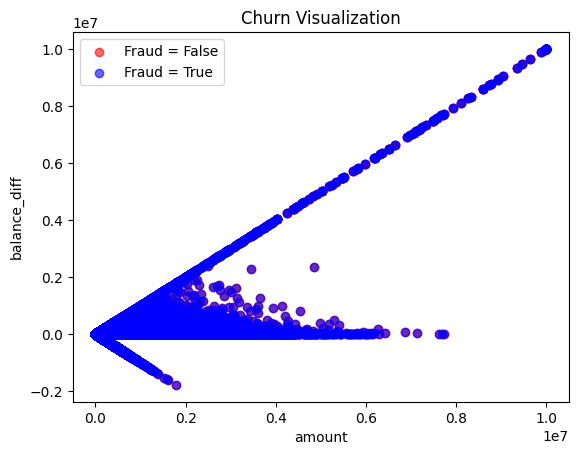

In [2]:
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=15)

feature_new = scaler.fit_transform(feature)
knn.fit(feature_new, target.ravel())


feature_new = np.array([
    [900000, 1000],      # 🚨 High amount, low balance → likely fraud
    [2500, 300000],      # ✅ Normal transfer → not fraud
    [1200000, 50000],    # 🚨 Large withdrawal, insufficient balance
    [15000, 200000],    # ✅ Small transaction, safe
    [800000, 800000],   # ⚠️ Borderline case
])

predictions = knn.predict(feature_new)

print('Predictions: {}'.format(predictions))



# Plot
plt.scatter(
    transactions_df['amount'],
    transactions_df['balance_diff'],
    color='red',
    label='Fraud = False',
    alpha=0.6
)

plt.scatter(
    transactions_df['amount'],
    transactions_df['balance_diff'],
    color='blue',
    label='Fraud = True',
    alpha=0.6
)

# Labels
plt.xlabel('amount')
plt.ylabel('balance_diff')
plt.legend()
plt.title('Churn Visualization')

plt.show()


In [6]:
knn = KNeighborsClassifier(n_neighbors=7)
feature_train , feature_test , target_train , target_test = train_test_split(feature,target,test_size=0.4,random_state=42)

knn.fit(feature_train,target_train)
y_pred = knn.predict(feature_test)


print(type(feature_test[0][0]))
print(type(y_pred[0]))

# print(feature_test)
# print(y_pred)

print(confusion_matrix(target_test,y_pred))
print(classification_report(target_test,y_pred))

<class 'numpy.float64'>
<class 'numpy.int64'>
[[799577     86]
 [   527    269]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    799663
           1       0.76      0.34      0.47       796

    accuracy                           1.00    800459
   macro avg       0.88      0.67      0.73    800459
weighted avg       1.00      1.00      1.00    800459



# Logistic Regressoin

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

feature_train , feature_test , target_train , target_test = train_test_split(feature,target,test_size=0.4,random_state=42)

logreg.fit(feature_train,target_train)
y_pred = logreg.predict(feature_test)
print(y_pred)

[0 0 0 ... 0 0 0]


# Predicting Probabilities

In [10]:
y_pred_probs = logreg.predict_log_proba(feature_test)[:,1]
print(y_pred_probs[0])

-6.712160097451463


/Users/apple/Documents Local/Mubashir Code/ML/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1352: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


# Probability Threshold Plotting ROC Curve

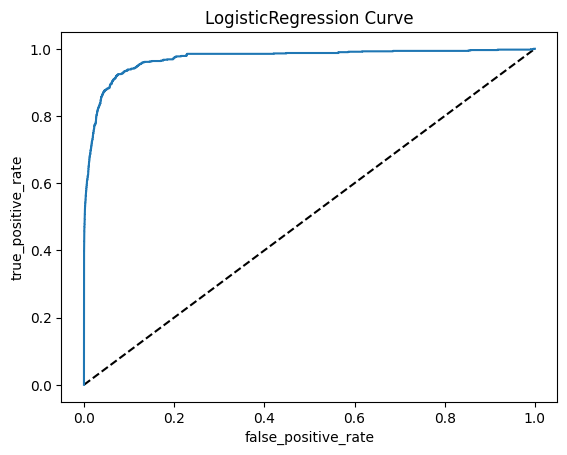

In [12]:
from sklearn.metrics import roc_curve
false_positive_rate , true_positive_rate , thresholds = roc_curve(target_test,y_pred_probs)

plt.plot([0,1],[0,1],'k--')
plt.plot(false_positive_rate,true_positive_rate)
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.title("LogisticRegression Curve")
plt.show()

# How to quantify the performace based on the graph
## We calculate the Area Under Curve

In [13]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(target_test,y_pred_probs))

0.9712674402220075


# Hyper Parameter Tuning

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score , KFold
from sklearn.linear_model import Ridge

kf = KFold(n_splits=5,shuffle=True,random_state=42)

param_grid = {"alpha" : np.arange(1,10,1),
              "solver" : ['sag' , 'lsqr']}

ridge = Ridge()
ridge_cv = GridSearchCV(ridge,param_grid,cv=kf)
ridge_cv.fit(feature_train,target_train)
print(ridge_cv.best_params_ , ridge_cv.best_score_)

{'alpha': np.int64(8), 'solver': 'sag'} 0.1067742315732145


# Grid Search Cv

In [19]:
from sklearn.model_selection import RandomizedSearchCV

kf = KFold(n_splits=5 , shuffle=True , random_state=42)
param_grid = {'alpha' : np.arange(1,10,1),
              'solver' : ['sag','lsqr']}
ridge = Ridge()
ridge_cv = RandomizedSearchCV(ridge,param_grid,cv=kf,n_iter=3)
ridge_cv.fit(feature_train,target_train)
print(ridge_cv.best_params_ , ridge_cv.best_score_)

{'solver': 'sag', 'alpha': np.int64(2)} 0.10677337895021324


In [20]:
test_score = ridge_cv.score(feature_test,target_test)
print(test_score)

0.09533105533499797
